# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import gensim
from gensim.utils import simple_preprocess
np.random.seed(2018)
import ast
import sklearn
from sklearn.decomposition import TruncatedSVD
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

In [2]:
df=pd.read_csv("train_clean_final.csv", converters={'text': eval})
df.head()

,id,keyword,location,target,text
0,1,NaN,NaN,1.0,"[deed, reason, earthquak, may, allah, forgiv, u]"
1,4,NaN,NaN,1.0,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,1.0,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,1.0,"[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,NaN,NaN,1.0,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [7]:
df2=pd.read_csv("test_clean_final.csv", converters={'text': eval})
df.head()

,id,keyword,location,target,text
0,1,NaN,NaN,1.0,"[deed, reason, earthquak, may, allah, forgiv, u]"
1,4,NaN,NaN,1.0,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,1.0,"[resid, ask, shelter, place, notifi, offic, ev..."
3,6,NaN,NaN,1.0,"[13000, peopl, receiv, wildfir, evacu, order, ..."
4,7,NaN,NaN,1.0,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


In [8]:
processed_docs=df['text']
processed_docs2=df2['text']

# Bag of Words

In [9]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary2 = gensim.corpora.Dictionary(processed_docs2)


In [10]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
dictionary2.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [11]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus2 = [dictionary2.doc2bow(doc) for doc in processed_docs2]

In [7]:
bow_doc_2000 = bow_corpus[2000]
for i in range(len(bow_doc_2000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2000[i][0], 
                                               dictionary[bow_doc_2000[i][0]], 
bow_doc_2000[i][1]))

Word 51 ("fast") appears 1 time.
Word 110 ("used") appears 1 time.
Word 150 ("great") appears 1 time.
Word 180 ("damage") appears 1 time.
Word 352 ("whole") appears 1 time.
Word 447 ("saw") appears 1 time.


# TF-IDF 

In [12]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
corpus_tfidf2 = tfidf[bow_corpus2]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5091708437330859), (1, 0.6748278354371504), (2, 0.5341839050470798)]


# LDA Bag of Words topics optimization

In [51]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    
    # generate LDA model
    return dictionary,doc_term_matrix

In [72]:
def compute_coherence_values_lda(dictionary, bow_corpus,doc_clean, start, stop, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #Training Parameters
    num_topics=20
    passes = 2 #equivalent of epoch
    iterations = 400
    eval_every = None
    workers=2
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = gensim.models.LdaMulticore(bow_corpus, 
                                       id2word=dictionary, 
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       workers=workers,
                                       eval_every=eval_every)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [64]:
def plot_graph_lda(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,start,stop, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

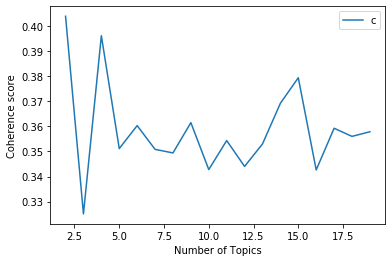

In [65]:
start,stop,step=2,20,1
plot_graph_lda(processed_docs,start,stop,step)


# LDA TF-IDF topics optimization

In [73]:
def prepare_corpus_tfidf(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    #Computing TF-IDF 
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[doc_term_matrix]
    # generate LDA model
    return dictionary,corpus_tfidf

In [74]:
def plot_graph_lda_tfidf(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values_lda(dictionary,doc_term_matrix,doc_clean,start,stop,step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

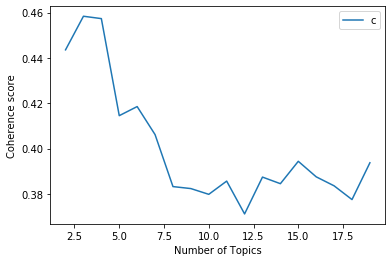

In [75]:
start,stop,step=2,20,1
plot_graph_lda_tfidf(processed_docs,start,stop,step)


# LDA Bag of words

In [72]:
#Training Parameters
num_topics=2
passes = 5 #equivalent of epoch
iterations = 400
eval_every = None
workers=2

#Model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       id2word=dictionary, 
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       workers=workers,
                                       eval_every=eval_every)

In [73]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"û" + 0.010*"news" + 0.010*"via" + 0.009*"video" + 0.008*"new" + 0.008*"police" + 0.007*"suicide" + 0.005*"attack" + 0.005*"nuclear" + 0.005*"youtube"
Topic: 1 
Words: 0.011*"like" + 0.010*"amp" + 0.009*"im" + 0.008*"get" + 0.008*"û" + 0.007*"fire" + 0.006*"dont" + 0.006*"us" + 0.006*"one" + 0.005*"disaster"


# LDA TF-IDF 

In [13]:
#Training Parameters
num_topics=3
passes = 20
iterations = 400
eval_every = None
workers=2
#Model
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, 
                                       id2word=dictionary, 
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       workers=workers,
                                       eval_every=eval_every)


In [14]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n Word: {}'.format(idx, topic))

Topic: 0 
 Word: 0.009*"storm" + 0.008*"disaster" + 0.006*"mass" + 0.006*"like" + 0.006*"one" + 0.005*"thunder" + 0.005*"via" + 0.005*"look" + 0.005*"death" + 0.005*"another"
Topic: 1 
 Word: 0.013*"fire" + 0.012*"im" + 0.009*"emergency" + 0.007*"nuclear" + 0.007*"burning" + 0.007*"û" + 0.007*"3" + 0.006*"crash" + 0.006*"us" + 0.006*"buildings"
Topic: 2 
 Word: 0.011*"video" + 0.009*"california" + 0.008*"û" + 0.008*"fires" + 0.008*"like" + 0.008*"youtube" + 0.007*"news" + 0.007*"may" + 0.007*"wildfire" + 0.006*"love"


# Performance LDA Bag of Words

In [ ]:
id=93

In [13]:
processed_docs.iloc[id]

['colorado',
 'avalanche',
 'mens',
 'official',
 'colorado',
 'avalanche',
 'reebok',
 'tshirt',
 'xl',
 'blue',
 '100',
 'cotton',
 'nhl',
 'hockey']

In [ ]:
for index, score in sorted(lda_model[bow_corpus[id]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

# Performance LDA TF-IDF

In [18]:
id=93

In [19]:
processed_docs.iloc[id]

['aashiqui', 'actress', 'anu', 'aggarwal', 'nearfatal', 'accident']

In [20]:
for index, score in sorted(lda_model_tfidf[bow_corpus[id]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6664155721664429	 
Topic: 0.013*"fire" + 0.012*"im" + 0.009*"emergency" + 0.007*"nuclear" + 0.007*"burning" + 0.007*"û" + 0.007*"3" + 0.006*"crash" + 0.006*"us" + 0.006*"buildings"

Score: 0.1668582260608673	 
Topic: 0.009*"storm" + 0.008*"disaster" + 0.006*"mass" + 0.006*"like" + 0.006*"one" + 0.005*"thunder" + 0.005*"via" + 0.005*"look" + 0.005*"death" + 0.005*"another"

Score: 0.16672618687152863	 
Topic: 0.011*"video" + 0.009*"california" + 0.008*"û" + 0.008*"fires" + 0.008*"like" + 0.008*"youtube" + 0.007*"news" + 0.007*"may" + 0.007*"wildfire" + 0.006*"love"


# Add to table

In [36]:
M=3
topic=[[] for i in range(M)]
for i in range(len(processed_docs)):
    for j in range(M):
        topic[j].append(lda_model_tfidf[bow_corpus[i]][j][1])

In [30]:
M=3
topic2=[[] for i in range(M)]
for i in range(len(processed_docs2)):
    for j in range(M):
        topic2[j].append(lda_model_tfidf[bow_corpus2[i]][j][1])

In [39]:
len(topic[2])

7613

In [41]:
for j in range(M):
    df['topic'+str(j+1)]=topic[j]
    df2['topic'+str(j+1)]=topic2[j]

In [42]:
df

,id,keyword,location,target,text,topic1,topic2,topic3
0,1,NaN,NaN,1.0,"[deed, reason, earthquak, may, allah, forgiv, u]",0.400448,0.088085,0.511507
1,4,NaN,NaN,1.0,"[forest, fire, near, la, rong, sask, canada]",0.072158,0.466595,0.461231
2,5,NaN,NaN,1.0,"[resid, ask, shelter, place, notifi, offic, ev...",0.861514,0.071005,0.067529
3,6,NaN,NaN,1.0,"[13000, peopl, receiv, wildfir, evacu, order, ...",0.128708,0.424875,0.446409
4,7,NaN,NaN,1.0,"[got, sent, photo, rubi, alaska, smoke, wildfi...",0.628407,0.304196,0.067411
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,1.0,"[two, giant, cranes, holding, bridge, collapse...",0.041718,0.042214,0.916062
7609,10870,NaN,NaN,1.0,"[ariaahrary, thetawniest, control, wild, fires...",0.042063,0.039027,0.918904
7610,10871,NaN,NaN,1.0,"[m194, 0104, utc5km, volcano, hawaii]",0.663844,0.166736,0.169416
7611,10872,NaN,NaN,1.0,"[police, investigating, ebike, collided, car, ...",0.047942,0.639909,0.312207


In [43]:
df2

,id,keyword,location,target,text,topic1,topic2,topic3
0,0,NaN,NaN,NaN,"[happened, terrible, car, crash]",0.442827,0.111232,0.445941
1,2,NaN,NaN,NaN,"[heard, earthquake, different, cities, stay, s...",0.086142,0.434642,0.479184
2,3,NaN,NaN,NaN,"[forest, fire, spot, pond, geese, fleeing, acr...",0.600592,0.302229,0.097179
3,9,NaN,NaN,NaN,"[apocalypse, lighting, spokane, wildfires]",0.192604,0.640481,0.166863
4,11,NaN,NaN,NaN,"[typhoon, soudelor, kills, 28, china, taiwan]",0.666273,0.166793,0.166934
...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,NaN,"[earthquake, safety, los, angeles, ûò, safety,...",0.721705,0.140893,0.137690
3259,10865,NaN,NaN,NaN,"[storm, ri, worse, last, hurricane, cityamp3ot...",0.566088,0.277921,0.156004
3260,10868,NaN,NaN,NaN,"[green, line, derailment, chicago]",0.167157,0.648354,0.184465
3261,10874,NaN,NaN,NaN,"[meg, issues, hazardous, weather, outlook, hwo]",0.777035,0.111193,0.111772


In [44]:
df.to_csv('train_lda.csv', index=None)
df2.to_csv('test_lda.csv', index=None)